# Проект: классификация

### Banking sector analysis

In [3]:
import re
import warnings
warnings.filterwarnings('ignore')

# импортируем бибилиотеки для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# импортируем алгоритмы машинного обучение из библиотеки sklearn
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from  sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# импортируем кодировщики и нормализаторы для наших данных
from sklearn import preprocessing 
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

# импортируем методы для кросс-валидации
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
# импортируем библиотеки для оптимизации гиперпараметров модели
import optuna
from sklearn.model_selection import GridSearchCV

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

**Business task: to determine the characteristics by which it is possible to identify customers who are more inclined to open a deposit in a bank, and thereby increase the effectiveness of a marketing campaign.<br />The technical task for you as a data scientist is to build a machine learning model that, based on the proposed characteristics of the client, will predict whether he will take advantage of the offer to open a deposit or not.**

### Задание 1

In [5]:
df = pd.read_csv('airflow_bank/data/bank_fin.csv', sep = ';')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'airflow_bank/data/bank_fin.csv'

<p>Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).
<br /><br /> Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).
<br /><br /> Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).<br />
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.</p>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


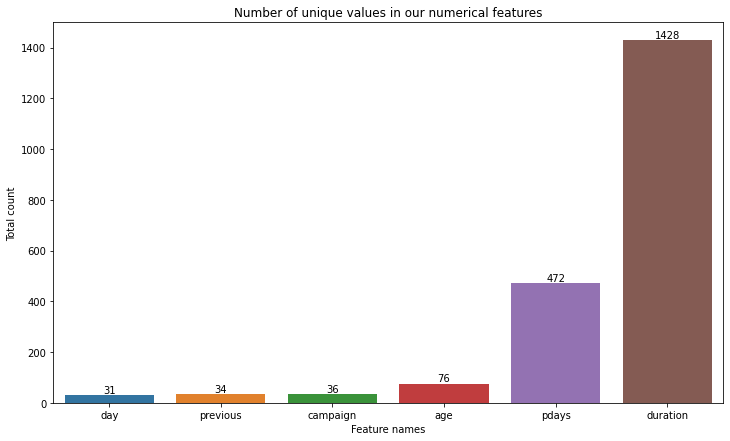

In [ ]:
unique_values = df.select_dtypes(include= 'number').nunique().sort_values()
fig, ax = plt.subplots(figsize = (12,7))
sns.barplot(x = unique_values.index, y= unique_values.values, ax= ax);
ax.set_title('Number of unique values in our numerical features')
ax.set_xlabel('Feature names')
ax.set_ylabel('Total count')
for i in ax.containers:
    ax.bar_label(i)


In [ ]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [ ]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].replace('[\s$]','',regex=True).apply(lambda x : str(x).split(',')[0]).astype('float')
print(np.round(df['balance'].mean(),3))

1529.129


### Задание 4

In [ ]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.fillna({'balance':df['balance'].median()}, inplace= True)
print(np.round(df['balance'].mean(),3))

1526.936


In [ ]:
print(df['job'].value_counts().index[-1])
print(df['education'].value_counts().index[-1])

unknown
unknown


### Задание 5

In [ ]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

In [ ]:
mask = (df['job'] == df['job'].value_counts().index[0]) & (df['education'] == df['education'].value_counts().index[0])
print(np.round(df[mask]['balance'].mean(),3))

1598.883


### Задание 6

In [ ]:
# удалите все выбросы для признака balance
def outliers_IQR(data, feature, left = 1.5, right = 1.5):
    x = data[feature]
    Q1, Q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = Q3 - Q1
    lower_bound = Q1 - iqr * left
    upper_bound = Q3 + iqr * right
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print('Lower Bound of outliers {:.0f}'.format(lower_bound))
    print('Upper Bound of outliers {:.0f}'.format(upper_bound))
    return cleaned
df = outliers_IQR(df, 'balance')
print('Объектов после удаления осталось {}'.format(df.shape))

Lower Bound of outliers -2241
Upper Bound of outliers 4063
Объектов после удаления осталось (10105, 17)


## Часть 2:  Разведывательный анализ

### Задание 1

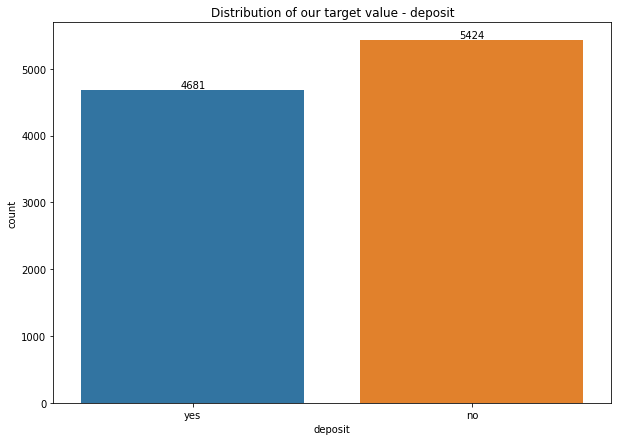

In [ ]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig1, ax1 = plt.subplots(figsize = (10,7))
sns.countplot(df['deposit'], ax=ax1)
for i in ax1.containers:
    ax1.bar_label(i)
ax1.set_title('Distribution of our target value - deposit');

### Задания 2 и 3

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,10105.0,40.895497,11.734931,18.0,32.0,38.0,48.0,95.0
balance,10105.0,807.653538,994.151966,-2049.0,95.0,445.0,1227.0,4063.0
day,10105.0,15.590302,8.441510,1.0,8.0,15.0,22.0,31.0
duration,10105.0,368.742603,346.651524,2.0,137.0,252.0,490.0,3881.0
campaign,10105.0,2.517170,2.707159,1.0,1.0,2.0,3.0,43.0
pdays,10105.0,51.319644,109.644179,-1.0,-1.0,-1.0,2.0,854.0
previous,10105.0,0.816230,2.243795,0.0,0.0,0.0,1.0,58.0


### Промежуточные выводы по описательным статистикам

In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

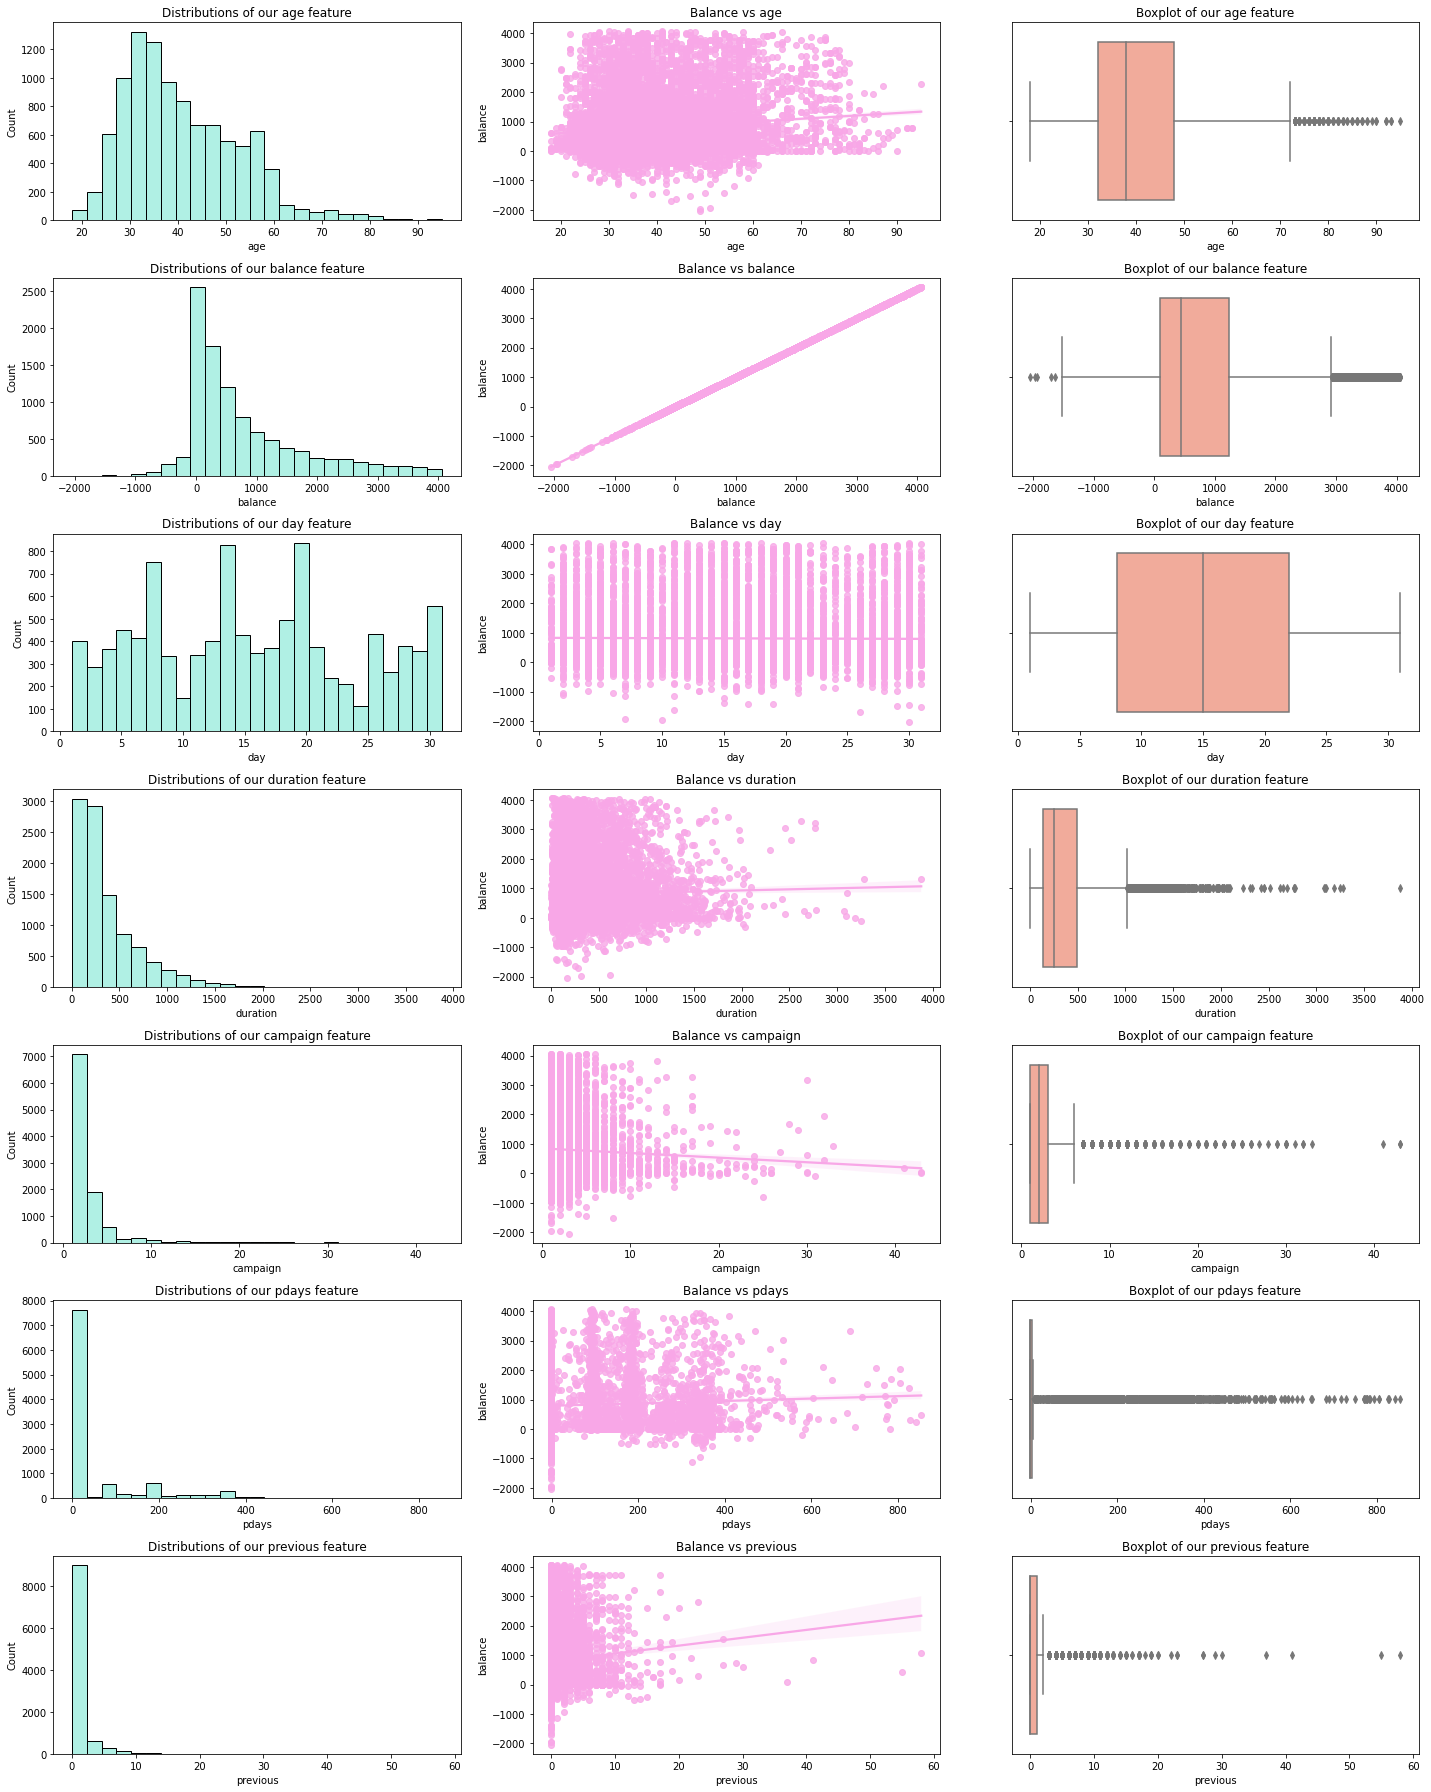

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
number_list = list(df.select_dtypes(include='number').columns)
n = len(number_list)
fig2, axes2 = plt.subplots(n, 3, figsize = (20,25))
for n, feature in enumerate(number_list):
    histogram = sns.histplot(data = df, x= feature, bins = 25, color= '#96ebdc', ax= axes2[n][0])
    histogram.set_title('Distributions of our {} feature'.format(feature))
    regplot = sns.regplot(data = df, x= feature, y = 'balance', color= '#f8a7e7',ax= axes2[n][1])
    regplot.set_title('Balance vs {}'.format(feature))
    boxplot = sns.boxplot(data = df, x= feature, orient = 'h', color= '#ffa28d',ax= axes2[n][2])
    boxplot.set_title('Boxplot of our {} feature'.format(feature))
plt.tight_layout()

### Промежуточные выводы по описательным статистикам

На основе наших количественных признаков мы построили три вида графикоф для подробной визуализации наших данных.
- Первый вид графика - гистограмма. Обращаем внимание но то, что большинство наших количественных признаков, таких как pdays, previous, campaign, duration имеют лог-нормальные распределения. Если посмотреть на третий тип нашего графика(ящик с усами), то можно обнаружить множество потенциальных выбросов в этих признаках. Почему потенциальных? Не во всех случаях слишком сильное отклонение от нашей средней или медианы означает обязательное присваивание этому значению метки выброса. Взять к примеру признак duration, означающий длительность разговора в секундах. Мы допускаем вероятность очень длительного разговора, где либо сотрудник, либо клиент может подолгу поддерживать беседу и уточнять разные данные (но нужно держать в уме, что это может быть выбросом). Максимальное значение длительности разовора - 1 час 3 минуты
- Также мы визуализировали график отношения баланса ко всем нашим количественным признакам. Зависимости, которые удалось обнаружить: с чем больше предыдущих контактов, тем больше баланс у нашего клиента (эта гипотеза нуждается в проверке, так ка около 70 процентов данных признкак предыдущих контактов равняется нулю). Также можно заметить, что с увеличением количества контактов во время кампании понижается баланс на счете клиента, что может быть индикатором того, что кампания успешна и клиент тратит свои накопления(эта гипотеза также нуждается в проверке)

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


#### Рассмотрим детальнее несколько категориальных признаков

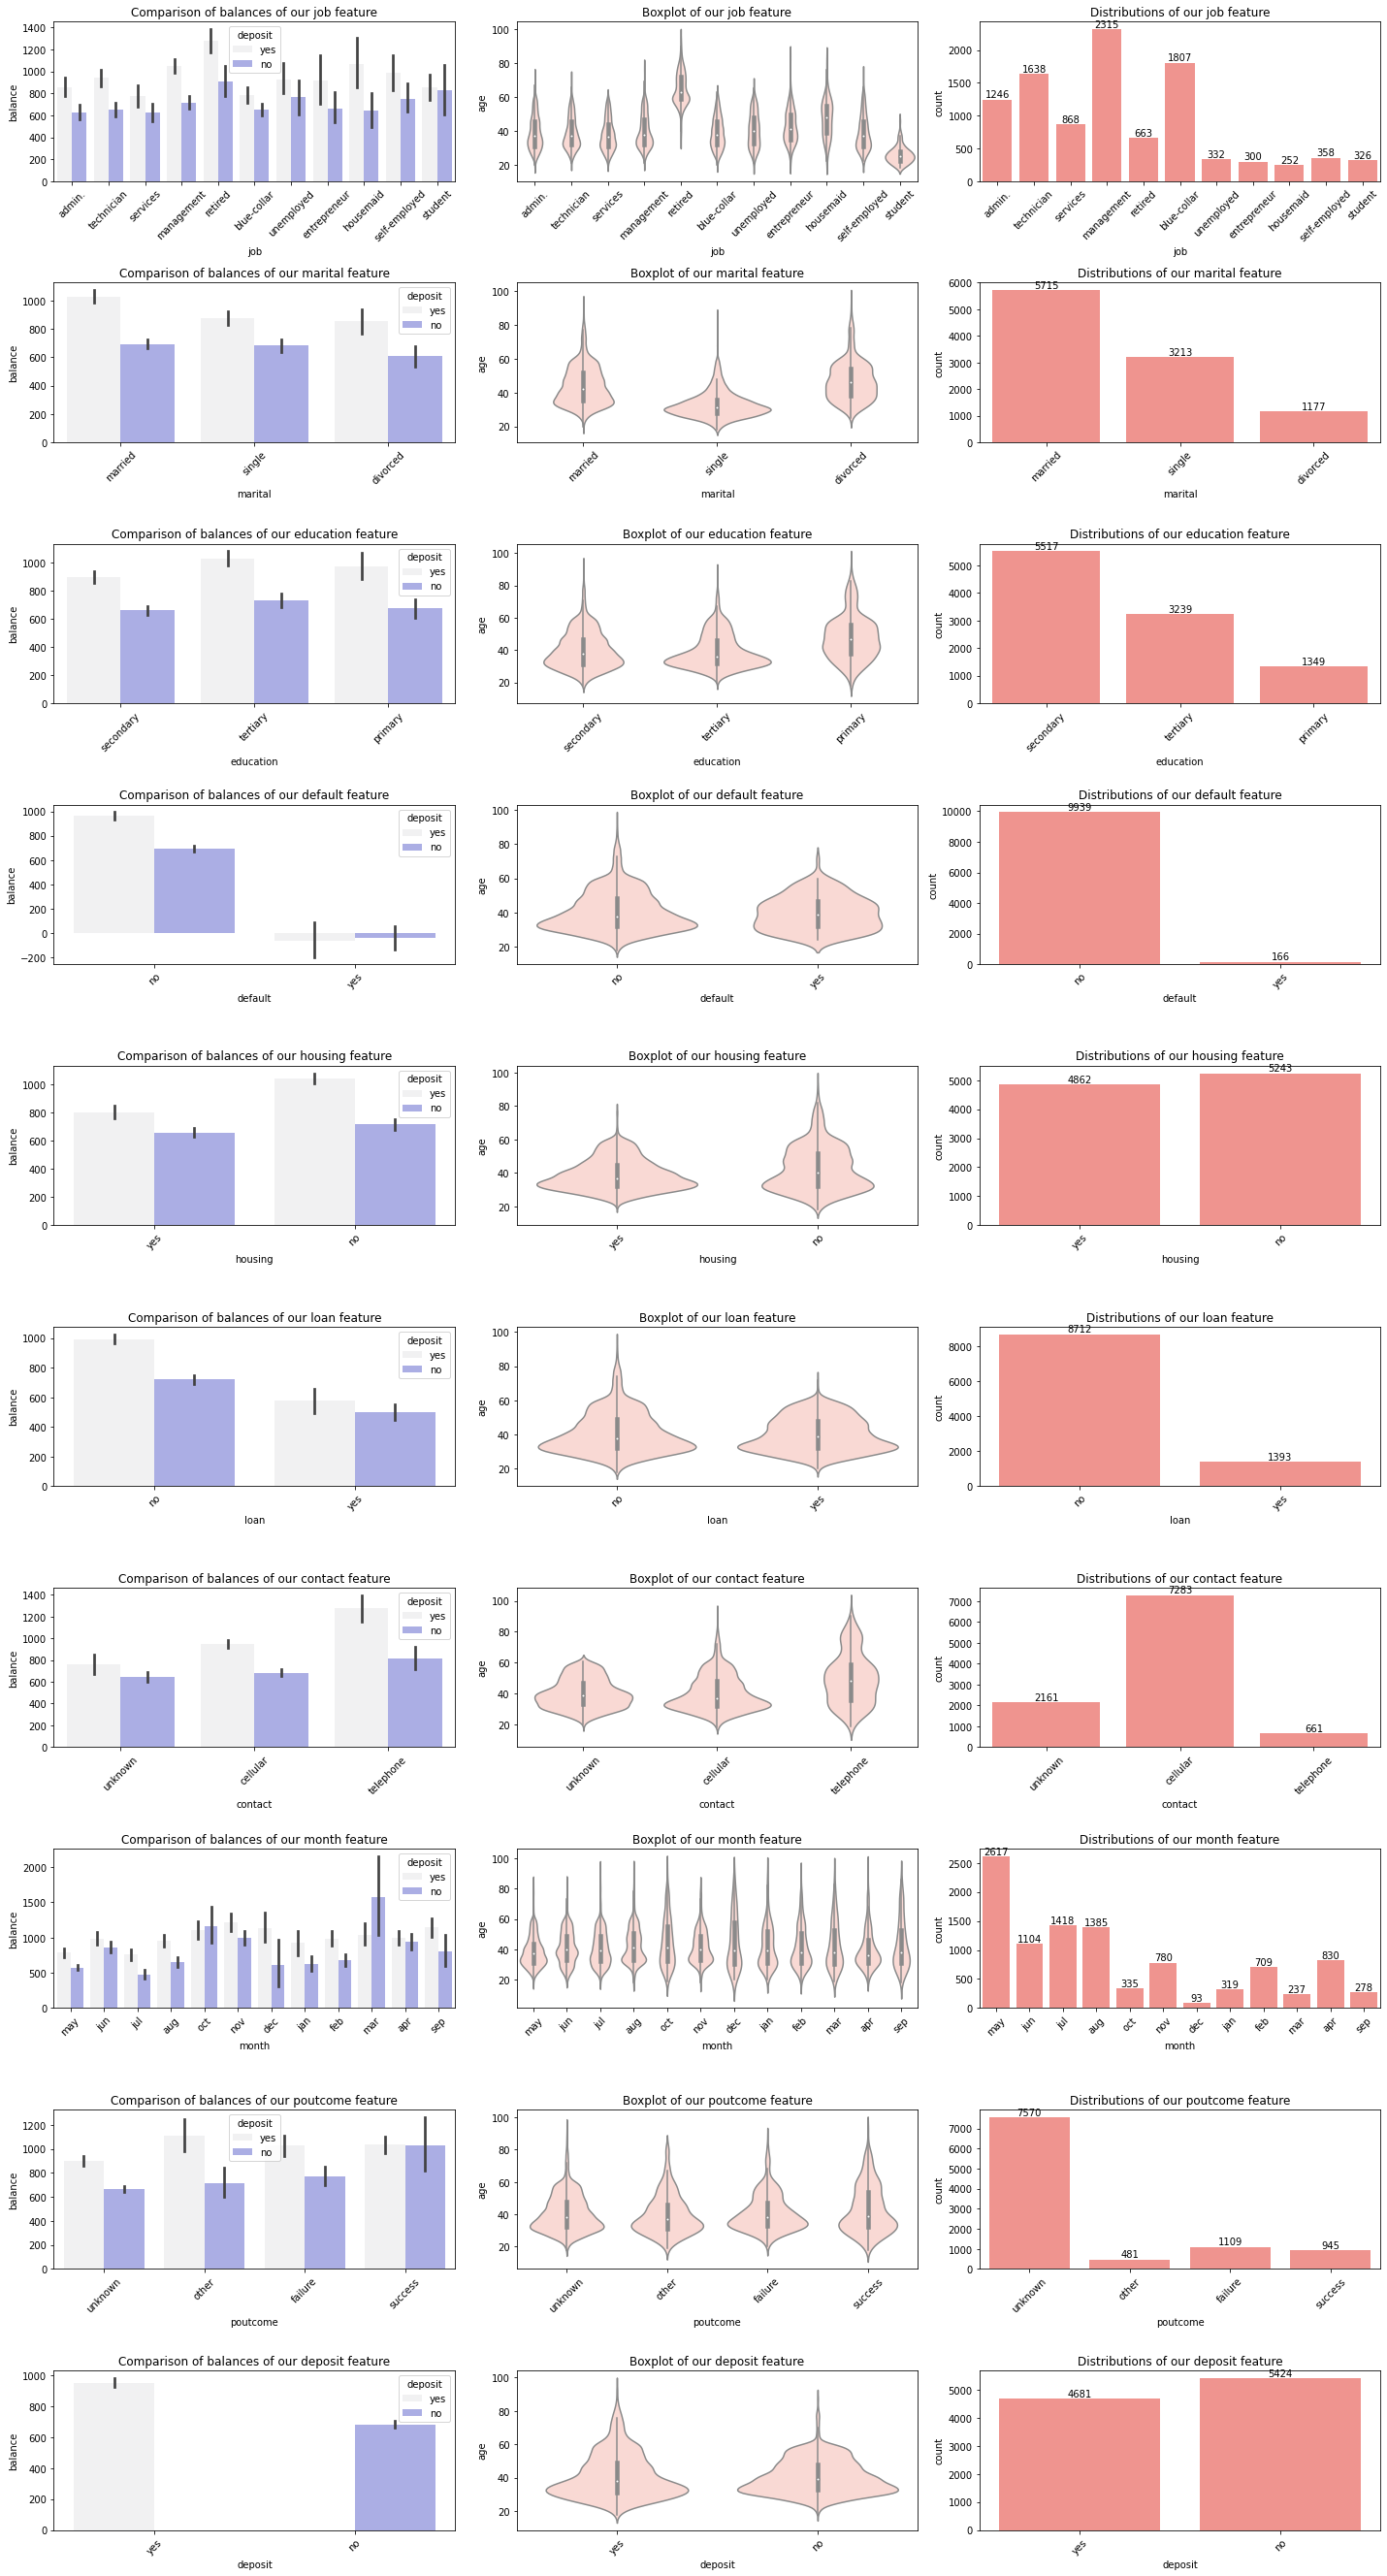

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
categorical_features = list(df.select_dtypes(include='object').columns)
i = len(categorical_features)
fig3, axes3 = plt.subplots(i, 3, figsize = (20,37))
for i, feature in enumerate(categorical_features):
    barplot = sns.barplot(data = df, x= feature, y= 'balance',hue= 'deposit', color= '#a1a6ee', ax= axes3[i][0])
    barplot.set_title('Comparison of balances of our {} feature'.format(feature))
    barplot.xaxis.set_tick_params(rotation = 45)
    violinplot = sns.violinplot(data = df, x= feature, y= 'age', color= '#ffd4ce',ax= axes3[i][1])
    violinplot.set_title('Boxplot of our {} feature'.format(feature))
    violinplot.xaxis.set_tick_params(rotation = 45)
    countplot = sns.countplot(data = df, x= feature, color= '#ff857f', ax= axes3[i][2])
    countplot.set_title('Distributions of our {} feature'.format(feature))
    countplot.xaxis.set_tick_params(rotation = 45)
    for i in countplot.containers:
        countplot.bar_label(i)
plt.tight_layout()

### Промежуточные выводы по категориальным переменным

После построения трех типов диаграм для наших категориальных переменных в разрезе баланса, возраста и общего количества клиентов можно выделить следующие закономерности.
- Большое количество открытых депозитов пришлось на клиентов-управленцев банка, которые в свою очереди обладают большим балансом, по сравнению с другими трудоустроенными. Сюда также можно добавить, что большая часть наших клиентов состоят в браке, следовательно и среди них больше открытых депозитов
- Интересная закономерность наблюдается среди тех, у кого имеется разного рода кредиты(на жилье, личные нужды и просроченные кредиты). Клиенты, необязанные банку кредиторными задолженностями более склонны открывать депозит в банке, что явяляется неудивительным, так как у них нет страха непогашения кредита или нехватки денег
- Также взглянем на временные промежутки контактов с нашими клиентами. Большая активность наблюдается, в основном, в жаркие периоды года. Такие как Май, Июнь, Август, Июль, что может обосновываться тем, что в эти месяцы начинаются периоды отпусков и люди активно контактируют с банками. Наименьший уровень активности контактов у нас наблюдается в зимние периоды года, с минимальным пиком приходящимся на декабрь
- Также интересное наблюдение связано с успешностью проведения предыдущей маркетинговой кампании. Вот например неочевидный факт: Те, кто посчитал маркетинговую кампанию провальной в прошлый раз, соглашались открыть депозит намного чаще, чем те, кто посчитал ее успешной

### Задание 6

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


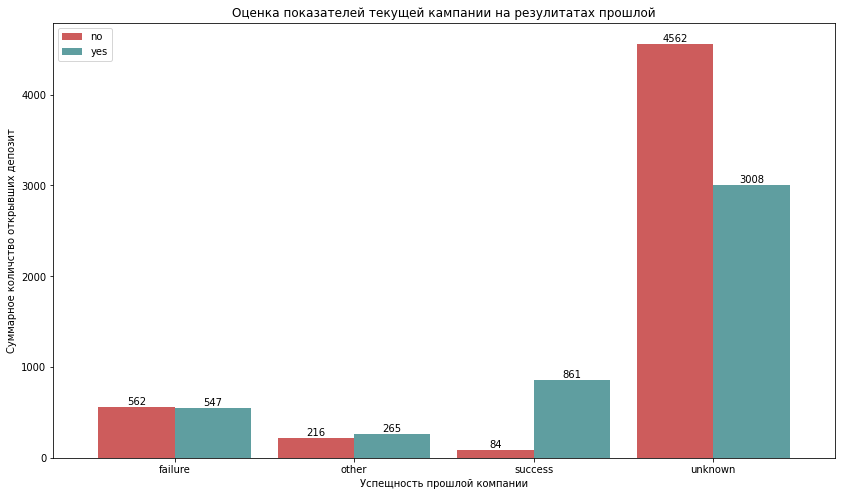

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

# приводим наш групированный по прошедшему показателю Series в форму датафрейма
grouped = df.groupby('poutcome')['deposit'].value_counts().unstack()
fig4, ax4 = plt.subplots(figsize = (14,8))
# визуализируем результат
plotted_group = grouped.plot(
    ax = ax4,
    kind='bar', 
    width=0.85, 
    color=['indianred', 'cadetblue', 'darksalmon', 'slateblue'],
    rot=0)
ax4.legend(loc='upper left')
ax4.set_title('Оценка показателей текущей кампании на резулитатах прошлой')
ax4.set_xlabel('Успещность прошлой компании')
ax4.set_ylabel('Суммарное количство открывших депозит')

for i in plotted_group.containers:
    plotted_group.bar_label(i)
# отобразим также наш датафрейм
display(grouped)

### Задание 7

'may'

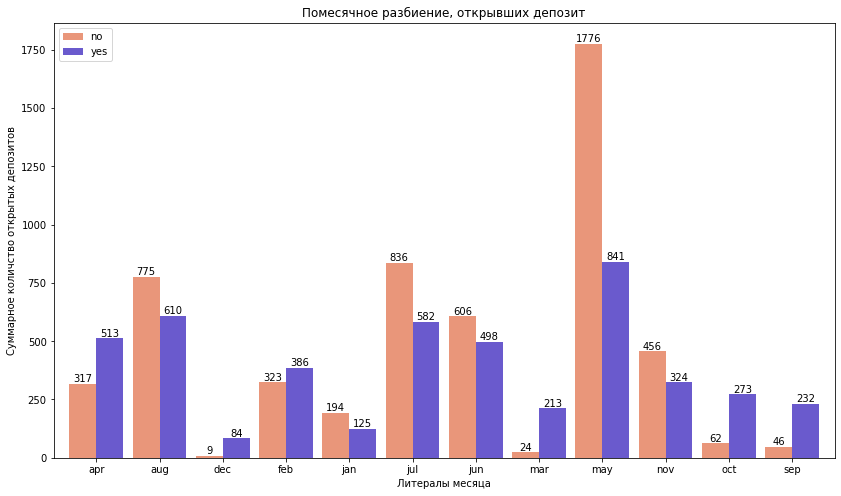

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# приводим наш групированный по прошедшему показателю Series в форму датафрейма
month_grouped = df.groupby('month')['deposit'].value_counts().unstack()
fig5, ax5 = plt.subplots(figsize = (14,8))
# визуализируем результат
plotted_month_group = month_grouped.plot(
    ax = ax5,
    kind='bar', 
    width=0.85, 
    color=['darksalmon', 'slateblue', 'indianred', 'cadetblue'],
    rot=0)
ax5.legend(loc='upper left')
ax5.set_title('Помесячное разбиение, открывших депозит')
ax5.set_xlabel('Литералы месяца')
ax5.set_ylabel('Суммарное количство открытых депозитов')
for i in plotted_month_group.containers:
    plotted_month_group.bar_label(i)
# отобразим также наш датафрейм
display(month_grouped['no'].sort_values().index[-1])

### Задание 8

deposit,no,yes
age_range,,
<30,819,1051
60+,97,416


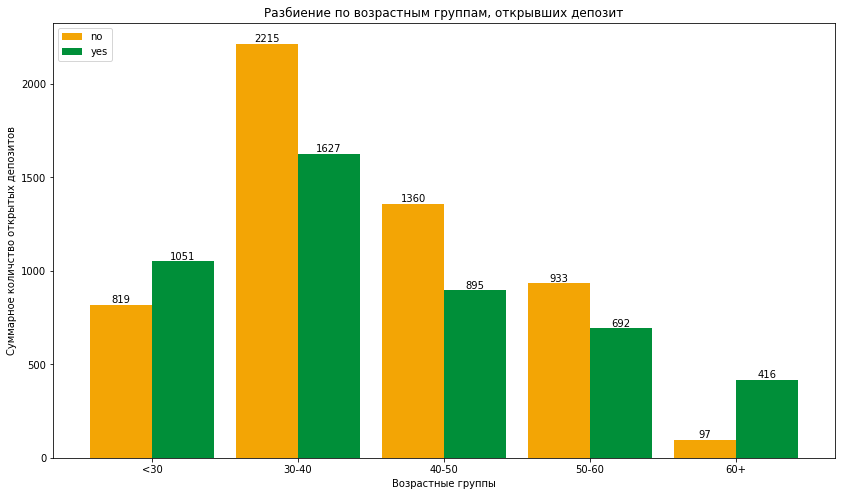

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_range'] = pd.cut(df['age'], [0,30,40,50,60,999],labels= ['<30','30-40','40-50','50-60','60+'], right=True)
df['age_range'].value_counts()

age_range_grouped = df.groupby('age_range')['deposit'].value_counts().unstack()
fig6, ax6 = plt.subplots(figsize = (14,8))
# визуализируем результат
plotted_age_group = age_range_grouped.plot(
    ax = ax6,
    kind='bar', 
    width=0.85, 
    color=['#F3A505', '#008F39'],
    rot=0)
ax6.legend(loc='upper left')
ax6.set_title('Разбиение по возрастным группам, открывших депозит')
ax6.set_xlabel('Возрастные группы')
ax6.set_ylabel('Суммарное количство открытых депозитов')
for i in plotted_age_group.containers:
    plotted_age_group.bar_label(i)
display(age_range_grouped[age_range_grouped['yes'] > age_range_grouped['no']])

### Задания 9 и 10

Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

- семейное положение;
- уровень образования;
- сфера занятости.

marital
single    1716
Name: yes, dtype: int64

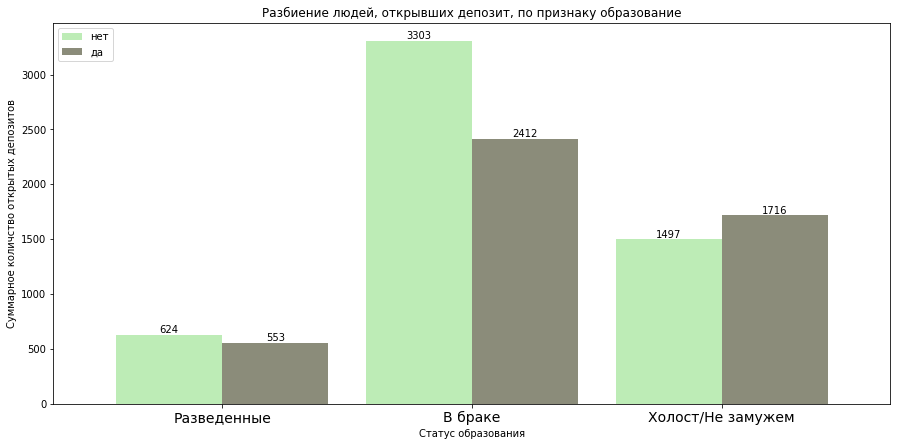

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

marital_grouped = df.groupby('marital')['deposit'].value_counts().unstack()
fig7, ax7 = plt.subplots(figsize = (15,7))
marital_status = ['Разведенные', 'В браке', 'Холост/Не замужем']
marital_grouped_plot = marital_grouped.plot(
    ax = ax7,
    kind='bar', 
    width=0.85, 
    color=['#BDECB6', '#8B8C7A'],
    label = marital_status,
    rot=0)
ax7.legend(['нет', 'да'], loc='upper left')
ax7.set_title('Разбиение людей, открывших депозит, по признаку образование')
ax7.set_xlabel('Статус образования')
ax7.set_xticklabels(marital_status, fontsize = 14)
ax7.set_ylabel('Суммарное количство открытых депозитов')
for i in marital_grouped_plot.containers:
    marital_grouped_plot.bar_label(i)
display(marital_grouped[marital_grouped['yes'] > marital_grouped['no']]['yes'])

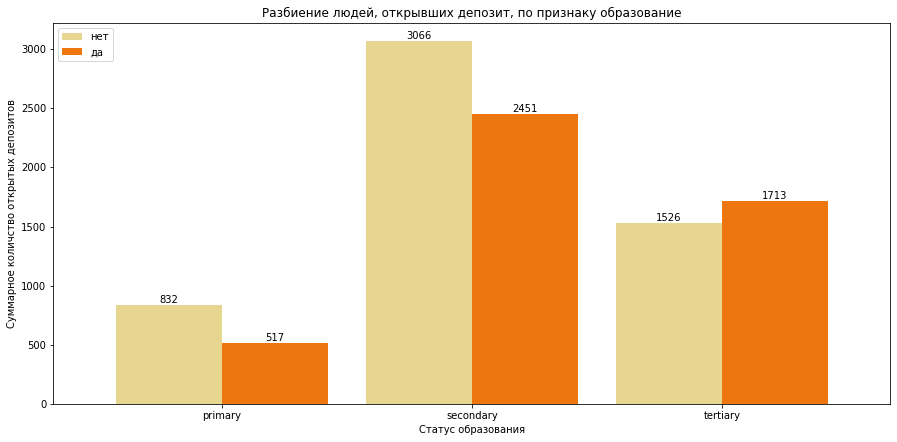

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
education_grouped = df.groupby('education')['deposit'].value_counts().unstack()
fig8, ax8 = plt.subplots(figsize = (15,7))
education_grouped_plot = education_grouped.plot(
    ax = ax8,
    kind='bar', 
    width=0.85, 
    color=['#E6D690', '#ED760E'],
    rot=0)
ax8.legend(['нет', 'да'], loc='upper left')
ax8.set_title('Разбиение людей, открывших депозит, по признаку образование')
ax8.set_xlabel('Статус образования')
ax8.set_ylabel('Суммарное количство открытых депозитов')
for i in education_grouped_plot.containers:
    education_grouped_plot.bar_label(i)


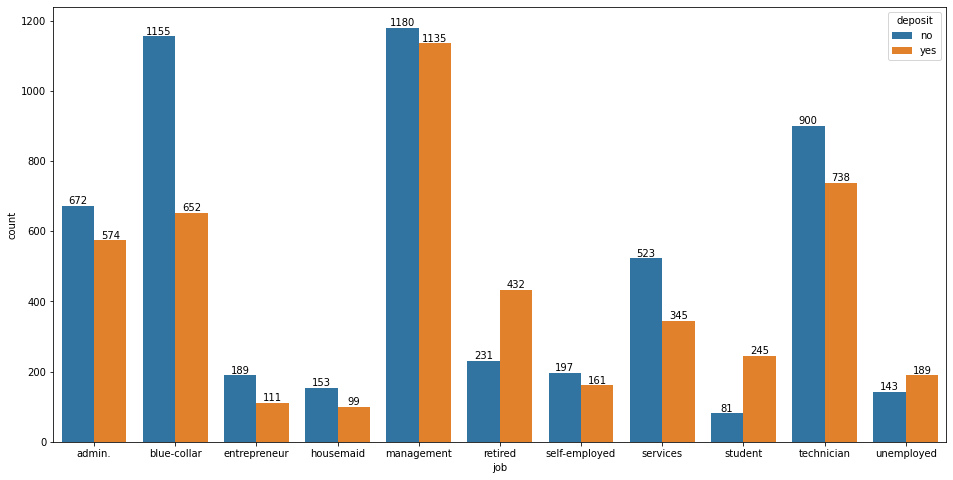

In [ ]:
job_grouped = df.groupby('job')['deposit'].value_counts()
# переводим в датафрейм
job_grouped = job_grouped.to_frame('count').reset_index()
fig9, ax9 = plt.subplots(figsize = (16,8))
barplot = sns.barplot(data = job_grouped,x= 'job', y= 'count', hue= 'deposit', ax= ax9)
job_grouped
for i in ax9.containers:
    ax9.bar_label(i)

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


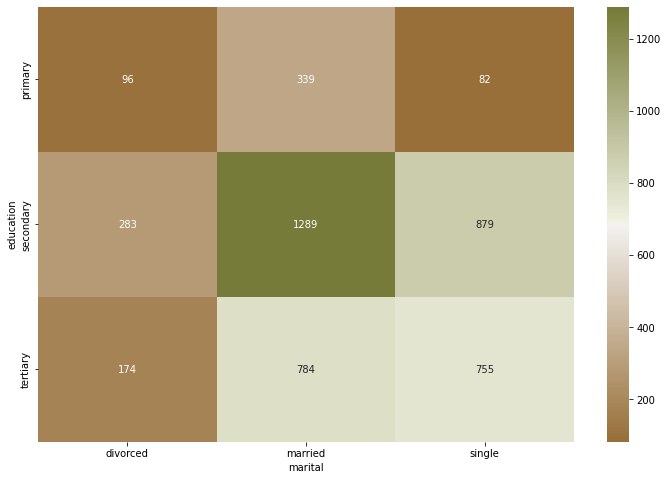

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_copy_yes = df[df['deposit'] == 'yes']
df_copy_no = df[df['deposit'] == 'no']

pivot_yes = pd.pivot_table(
    df_copy_yes,
    values= 'deposit',
    index='education',
    columns='marital',
    aggfunc= 'count'
)
display(pivot_yes)
fig10, ax10 = plt.subplots(figsize = (12,8))
heatmap = sns.heatmap(data= pivot_yes,cmap=sns.diverging_palette(50, 90, n=200), annot= True, fmt='d')


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


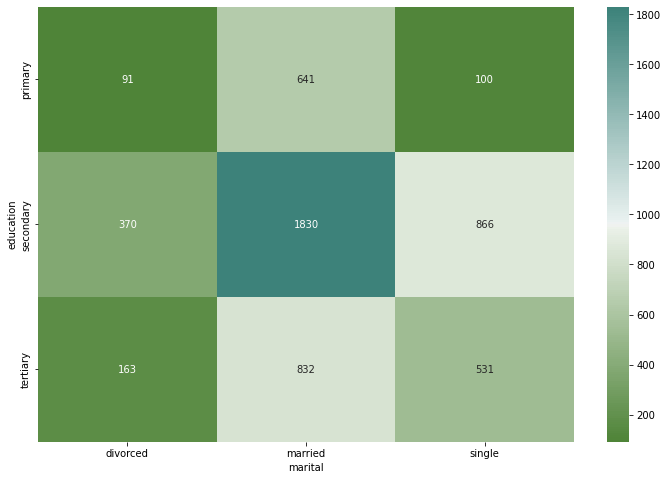

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто не открыл депозит)
pivot_no = pd.pivot_table(
    df_copy_no,
    values= 'deposit',
    index='education',
    columns='marital',
    aggfunc= 'count'
)
display(pivot_no)
fig11, ax11 = plt.subplots(figsize = (12,8))
heatmap = sns.heatmap(data= pivot_no,cmap=sns.diverging_palette(120, 180, n=200), annot= True, fmt='d')


marital,divorced,married,single
job,,,
admin.,82,273,219
blue-collar,52,401,199
entrepreneur,14,71,26
housemaid,16,61,22
management,119,602,414
retired,104,315,13
self-employed,19,65,77
services,48,159,138
student,1,10,234


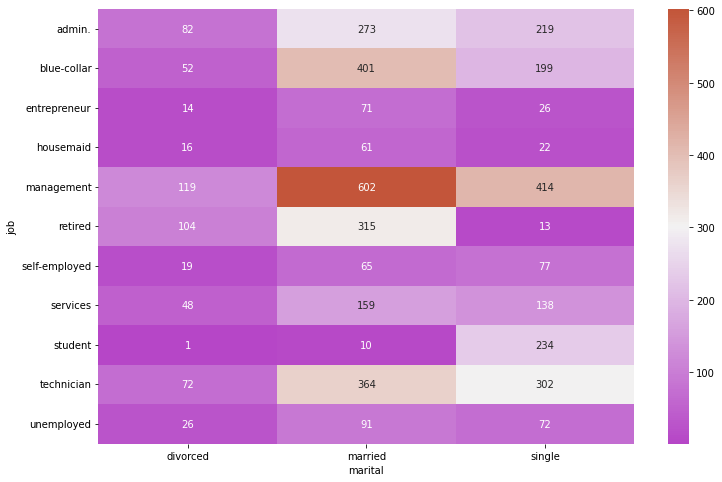

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто не открыл депозит)
pivot_no = pd.pivot_table(
    df_copy_yes,
    values= 'deposit',
    index='job',
    columns='marital',
    aggfunc= 'count'
)
display(pivot_no)
fig11, ax11 = plt.subplots(figsize = (12,8))
heatmap = sns.heatmap(data= pivot_no,cmap=sns.diverging_palette(300, 380, n=200), annot= True, fmt='d')


marital,divorced,married,single
job,,,
admin.,89,355,228
blue-collar,87,831,237
entrepreneur,26,141,22
housemaid,24,116,13
management,131,699,350
retired,44,175,12
self-employed,14,131,52
services,69,302,152
student,1,5,75


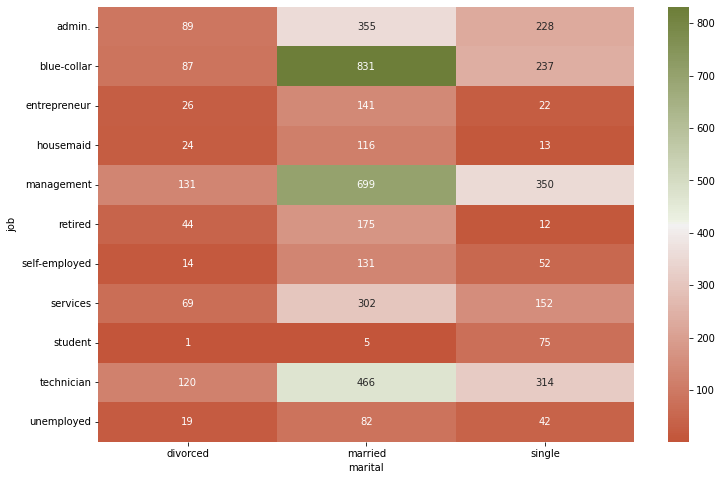

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто не открыл депозит)
pivot_no = pd.pivot_table(
    df_copy_no,
    values= 'deposit',
    index='job',
    columns='marital',
    aggfunc= 'count'
)
display(pivot_no)
fig11, ax11 = plt.subplots(figsize = (12,8))
heatmap = sns.heatmap(data= pivot_no,cmap=sns.diverging_palette(20, 100, n=200), annot= True, fmt='d')


<p>Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).
<br /><br /> Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).
<br /><br /> Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).
И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.</p>

## Часть 3: преобразование данных

### Задание 1

In [ ]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].sum()
# преобразуйте уровни образования

11995

In [ ]:
df['age_range'] = le.fit_transform(df['age_range'])
df.describe()
df.describe(include='object')

,job,marital,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,2,2,2,3,12,4,2
top,management,married,no,no,no,cellular,may,unknown,no
freq,2315,5715,9939,5243,8712,7283,2617,7570,5424


### Задания 2 и 3

In [ ]:
df.nunique()

age            76
job            11
marital         3
education       3
default         2
balance      2963
housing         2
loan            2
contact         3
day            31
month          12
duration     1390
campaign       35
pdays         458
previous       30
poutcome        4
deposit         2
age_range       5
dtype: int64

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц
lb = LabelBinarizer()

# Найдем все бинарные признаки
binary_features = [feature for feature in df.columns if df[feature].nunique() == 2]

for item in binary_features:
    df[item] = lb.fit_transform(df[item])
display(np.round(df['deposit'].std(),3))
binary_features.remove('deposit')

0.499

In [ ]:
mean_list = []
for feat in binary_features:
    mean_list.append(df[feat].mean())
display(round(sum(mean_list),3))

0.635

### Задание 4

In [ ]:
# создайте дамми-переменные
dummy_df = pd.get_dummies(df)
dummy_df.drop(columns= 'age', inplace = True)

### Задания 5 и 6

<AxesSubplot:>

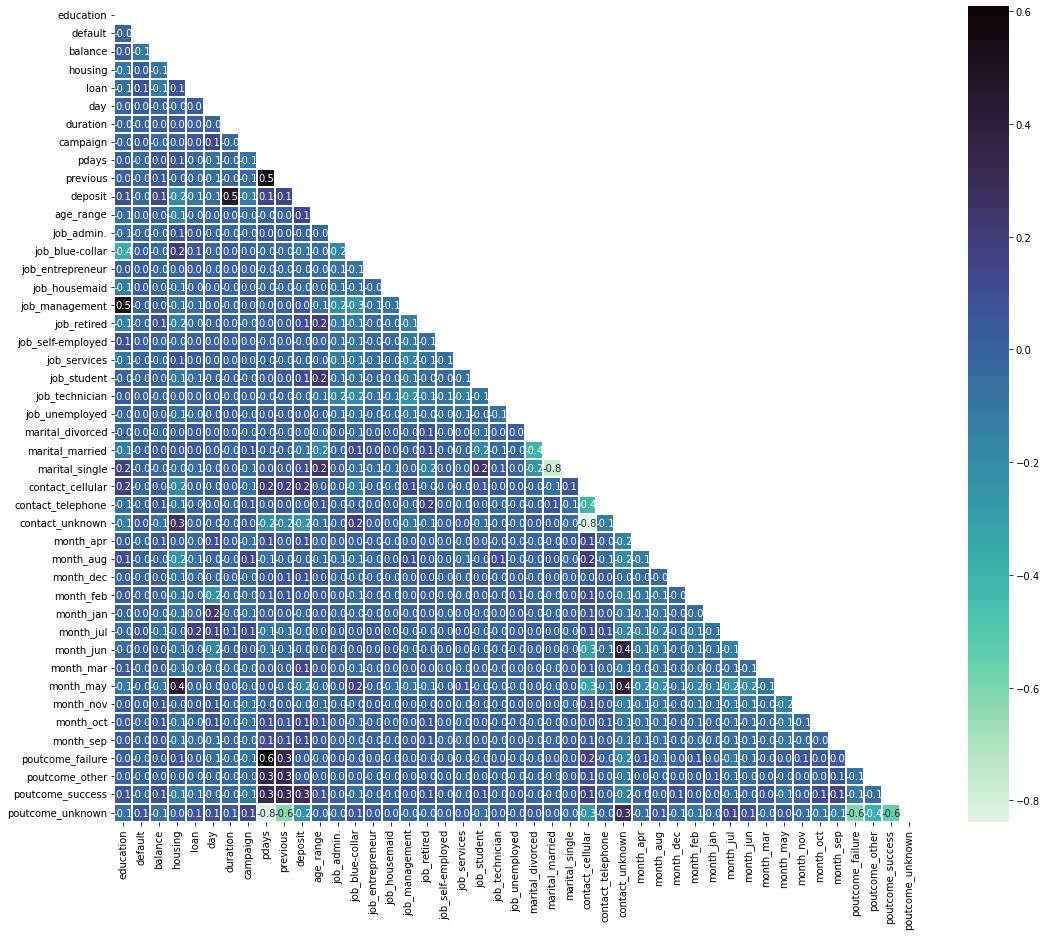

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig12, ax12 = plt.subplots(figsize = (18,15))
corr = dummy_df.corr()
sns.heatmap(corr,
            mask = np.triu(np.ones_like(corr, dtype=bool)),
            linewidths=0.1, 
            cmap = 'mako_r',
            fmt = '.1f',
            annot=True)

### Задания 7 и 8

In [ ]:
X = dummy_df.drop(['deposit'], axis=1)
y = dummy_df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели
display(X_train.shape)
display(X_test.shape)

(6770, 44)

(3335, 44)

In [ ]:
display(np.round(y_test.mean(),2))

0.46

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k = 15)
selector.fit(X_train, y_train)
main_features = list(selector.get_feature_names_out())
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
display(main_features)

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_range',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
display(round(np.mean(X_test_scaled[:,0]),2))

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver= 'sag',max_iter= 1000, random_state= 42)
log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth= 6,random_state= 42)
decision_tree.fit(X_train_scaled, y_train)
y_tree_train = decision_tree.predict(X_train_scaled)
y_tree_pred = decision_tree.predict(X_test_scaled)
print('Accuracy score for train :{:.2f}'.format(metrics.accuracy_score(y_train, y_tree_train)))
print('Accuracy score :{:.2f}'.format(metrics.accuracy_score(y_test, y_tree_pred)))

Accuracy score for train :0.82
Accuracy score :0.81


### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
               'max_depth':[3,5,7]}
grid_search = GridSearchCV(
    estimator= decision_tree,
    param_grid= param_grid,
    cv = 3,
    n_jobs= -1,
    scoring= 'accuracy',
    return_train_score= True
)
grid_search.fit(X_train_scaled, y_train)
y_gs_train_pred = grid_search.predict(X_train_scaled)
y_gs_pred = grid_search.predict(X_test_scaled)
print('Accuracy : {:.2f}'.format(grid_search.score(X_test_scaled, y_test)))
print('F1-score : {:.2f}'.format(metrics.f1_score(y_test, y_gs_pred)))
print("Best Hyperparams: {}".format(grid_search.best_params_))

Accuracy : 0.81
F1-score : 0.80
Best Hyperparams: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес
random_forest = ensemble.RandomForestClassifier(
    n_estimators= 100,
    criterion= 'gini',
    min_samples_leaf= 5,
    max_depth=10,
    random_state= 42
)
random_forest.fit(X_train_scaled, y_train)
y_rf_pred = random_forest.predict(X_test_scaled)
print('Accuracy(random forest) for test df : {:.2f}'.format(random_forest.score(X_test_scaled, y_test)))
print('Recall(random forest) for test df : {:.2f}'.format(metrics.recall_score(y_test, y_rf_pred)))
print('F1-score(random forest) for test df : {:.2f}'.format(metrics.f1_score(y_test, y_rf_pred)))


Accuracy(random forest) for test df : 0.83
Recall(random forest) for test df : 0.83
F1-score(random forest) for test df : 0.82


### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gradient_boosting = GradientBoostingClassifier(
    max_depth= 7,
    n_estimators= 100,
    random_state= 42
)
gradient_boosting.fit(X_train_scaled, y_train)
y_gb_pred = gradient_boosting.predict(X_test_scaled)
print('Accuracy(gradient boosting) for test df : {:.2f}'.format(gradient_boosting.score(X_test_scaled, y_test)))
print('Recall(gradient boosting) for test df : {:.2f}'.format(metrics.recall_score(y_test, y_gb_pred)))

Accuracy(gradient boosting) for test df : 0.83
Recall(gradient boosting) for test df : 0.83


### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('rf', random_forest),
    ('gb', gradient_boosting)
]
stack_clas = StackingClassifier(
    estimators= estimators,
    final_estimator=  log_reg
)
stack_clas.fit(X_train_scaled, y_train)
y_stack_pred = stack_clas.predict(X_test_scaled)
print('Accuracy(stacking) for test df : {:.2f}'.format(stack_clas.score(X_test_scaled, y_test)))
print('Precision (stacking) for test df : {:.2f}'.format(metrics.precision_score(y_test, y_stack_pred)))

Accuracy(stacking) for test df : 0.83
Precision (stacking) for test df : 0.81


### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feature_importances = list(gradient_boosting.feature_importances_)
feat_imp_lst = zip(main_features, feature_importances)
display(sorted(list(feat_imp_lst), key= lambda t:t[1], reverse= True))

[('duration', 0.46515892894853716),
 ('poutcome_success', 0.1145698481909197),
 ('balance', 0.09884587506233124),
 ('contact_unknown', 0.06687561443835104),
 ('pdays', 0.05082087312481326),
 ('age_range', 0.047165401955675194),
 ('housing', 0.04346011793386205),
 ('campaign', 0.025937868987832683),
 ('month_mar', 0.024169382820467412),
 ('month_oct', 0.018048232657648103),
 ('month_may', 0.014025461666239705),
 ('previous', 0.012431403774994855),
 ('month_sep', 0.011538191119342322),
 ('contact_cellular', 0.004774432684374053),
 ('poutcome_unknown', 0.0021783666346109577)]

### Задания 6,7,8

Optuna with Random forest

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
def tuning(obj, n_trials = 20):
    study = optuna.create_study(direction="maximize")
    study.optimize(obj, n_trials= n_trials)
    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {params}")
    return params
  
def optuna_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    scores = cross_val_score(
        model, X_train_scaled, y_train, cv=kfolds, scoring="f1"
    )
    return scores.mean()
    # обучаем модель
    
random_forest_params = tuning(optuna_random_forest , 300)

[I 2022-09-28 15:44:26,139] A new study created in memory with name: no-name-0cb0c97a-c32a-4d85-b034-c403caec3cff
[I 2022-09-28 15:44:28,079] Trial 0 finished with value: 0.8218711838866921 and parameters: {'n_estimators': 167, 'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8218711838866921.
[I 2022-09-28 15:44:29,679] Trial 1 finished with value: 0.8222365138175425 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8222365138175425.
[I 2022-09-28 15:44:31,593] Trial 2 finished with value: 0.8219290498242152 and parameters: {'n_estimators': 159, 'max_depth': 23, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8222365138175425.
[I 2022-09-28 15:44:33,007] Trial 3 finished with value: 0.8222075951578816 and parameters: {'n_estimators': 115, 'max_depth': 21, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8222365138175425.
[I 2022-09-28 15:44:34,310] Trial 4 finished with value: 0.82203812866749

Best score: 0.8289967983283392
Optimized parameters: {'n_estimators': 172, 'max_depth': 12, 'min_samples_leaf': 3}


In [ ]:
rf_model = ensemble.RandomForestClassifier(**random_forest_params, random_state= 42, n_jobs= -1)
rf_model.fit(X_train_scaled,y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)
print(rf_model.score(X_test_scaled, y_test))
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

0.8266866566716642
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3634
           1       0.85      0.88      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=500,
                           random_state= 42,
                           loss_function='Logloss',
                           eval_metric= 'F1',
                           verbose=True)
# train the model
model.fit(X_train_scaled, y_train)
# make the prediction using the resulting model
y_pred_train_cat = model.predict(X_train_scaled)
y_pred_cat = model.predict(X_test_scaled)
y_pred_cat_proba = model.predict_proba(X_test_scaled)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_pred_cat))

Learning rate set to 0.044019
0:	learn: 0.7910357	total: 3.2ms	remaining: 1.59s
1:	learn: 0.7976324	total: 5.38ms	remaining: 1.34s
2:	learn: 0.7951885	total: 7.74ms	remaining: 1.28s
3:	learn: 0.7940750	total: 13.4ms	remaining: 1.66s
4:	learn: 0.7994871	total: 16.9ms	remaining: 1.67s
5:	learn: 0.7981947	total: 19ms	remaining: 1.56s
6:	learn: 0.8007737	total: 22ms	remaining: 1.55s
7:	learn: 0.7980598	total: 24.9ms	remaining: 1.53s
8:	learn: 0.7970827	total: 27.7ms	remaining: 1.51s
9:	learn: 0.7996761	total: 30.3ms	remaining: 1.48s
10:	learn: 0.8020665	total: 32.6ms	remaining: 1.45s
11:	learn: 0.8049526	total: 34.9ms	remaining: 1.42s
12:	learn: 0.8047565	total: 37.6ms	remaining: 1.41s
13:	learn: 0.8104575	total: 40.7ms	remaining: 1.41s
14:	learn: 0.8078092	total: 44.5ms	remaining: 1.44s
15:	learn: 0.8096000	total: 48.8ms	remaining: 1.48s
16:	learn: 0.8105516	total: 52.1ms	remaining: 1.48s
17:	learn: 0.8120109	total: 55.1ms	remaining: 1.48s
18:	learn: 0.8115710	total: 59.6ms	remaining: 1.5